# Reading in the files and imports

In [1]:
import pyspark.sql.functions as F
import pandas as pd 
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

import os 
import pickle
import re
from datetime import datetime
import requests
import pytz
import pandas as pd
import numpy as np
import ast


In [2]:

import pyspark
# create spark context
sc = pyspark.SparkContext()
# create spark session 
spark = pyspark.sql.SparkSession(sc)

#path_json = ".././../data/Topic_vegan/*.json" 

#df_json = spark.read.option("multiline","true").json(path_json)

22/12/04 12:25:01 WARN Utils: Your hostname, MacBook-Pro-de-Elena.local resolves to a loopback address: 127.0.0.1; using 192.168.0.198 instead (on interface en0)
22/12/04 12:25:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/04 12:25:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
#reading in all keto files 
list_brands = ["healthyfood", 
               "healthylifestyle",
               "vegan",
               "keto",
               "ketodiet",
               "ketolifestyle",
               "veganism",
               "vegetarian"] 
from re import search

data_dir = ".././../data/Topic_vegan/"
tweet_files = [os.path.join(data_dir, obs) for obs in os.listdir(data_dir)]

files_brand = [file for file in tweet_files if (file.find(list_brands[5]) != -1)]
files_brand               
               
df_brand = spark.read.option("multiline","true").json(files_brand)  
df_brand.count() 
               

22/12/04 12:25:10 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


3744

In [7]:
spark

## Selecting the correct columns, converting types and checking for doubles 

In [4]:
# twitter represents likes as hearts 
# the number of likes different topics receive over time 
# use favorites_count 

#plot aantal tweets over een topic over time 

df_json_sub = df_brand.select(F.col("user.name"),
                                F.col("user.screen_name"),
                                F.col("created_at"), 
                                F.col("full_text"),
                                F.col("entities.hashtags"),
                                F.col("lang"),
                                F.col("favorite_count"),
                                F.col("user.followers_count"),
                                F.col("user.friends_count"),
                                F.col("user.favourites_count"),
                                F.col("entities.urls"),
                                F.col("entities.symbols"), 
                                )
#date --> time stamp variable 
def getDate(date):
    if date is not None:
        return str(datetime.strptime(date,'%a %b %d %H:%M:%S +0000 %Y').replace(tzinfo=pytz.UTC).strftime("%Y-%m-%d %H:%M:%S"))
    else:
        return None
date_udf = F.udf(getDate, StringType())
df_json_sub = df_json_sub.withColumn('post_created_at', F.to_utc_timestamp(date_udf("created_at"), "UTC"))

#extract year, month, day 

df_json_sub = df_json_sub.withColumn('year', year('post_created_at'))
df_json_sub = df_json_sub.withColumn('month', month('post_created_at'))
df_json_sub = df_json_sub.withColumn('day', dayofmonth('post_created_at')) #number from 1 to 31 
df_json_sub = df_json_sub.withColumn('week', weekofyear('post_created_at')) #week number from 1 to 52 

#df_json_sub.count() #3428559 



In [5]:
#drop duplicates and retweets 
df_json_sub = df_json_sub.filter(~F.col("full_text").startswith("RT"))\
                        .drop_duplicates()
#sorting such when dropping later we only keep the most recent post 
df_json_sub = df_json_sub.sort("post_created_at", ascending=False)
#removing spam accounts 
df_json_sub = df_json_sub.drop_duplicates(["full_text", "screen_name"])
                        
df_json_sub.printSchema()
#df_json_sub.count() #1340938 

root
 |-- name: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- full_text: string (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- text: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- friends_count: long (nullable = true)
 |-- favourites_count: long (nullable = true)
 |-- urls: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- display_url: string (nullable = true)
 |    |    |-- expanded_url: string (nullable = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- url: string (nullable = true)
 |-- symbols: array (nullable = true)
 |   

# 1. Data Cleaning 

In [6]:
# define function to count hashtags
def get_hashtags(tokenized_text):
    counter = 0
    for word in tokenized_text:
        if "#" in word:
            counter += 1
    return(counter) 

# define function to count mentions
def get_mentions(tokenized_text):
    counter = 0
    for word in tokenized_text:
        if "@" in word:
            counter += 1
    return(counter)

# define function to count exclamation marks
def get_exclamation_marks(tokenized_text):
    counter = 0
    for word in tokenized_text:
        if "!" in word:
            counter += 1
    return(counter)

# define function to count number of emojis used

import emojis
def emoji_counter(text):
    nr_emojis = emojis.count(text)
    return(nr_emojis)

# register functions as udf
get_hashtags_UDF = F.udf(get_hashtags, IntegerType())
get_mentions_UDF = F.udf(get_mentions, IntegerType())
get_exclamation_marks_UDF = F.udf(get_exclamation_marks, IntegerType())
emoji_counter_udf = F.udf(emoji_counter, IntegerType())


In [7]:

twitter_df = df_json_sub.withColumn("text_tokenized", F.split("full_text", " ")) \
                            .withColumn("num_words", F.size("text_tokenized")) \
                            .withColumn("num_hashtags", get_hashtags_UDF("text_tokenized")) \
                            .withColumn("num_mentions", get_mentions_UDF("text_tokenized")) \
                            .withColumn("num_exclamation_marks", get_exclamation_marks_UDF("text_tokenized")) \
                            .withColumn("emoji_count", emoji_counter_udf("full_text")) 
twitter_df.printSchema()


root
 |-- name: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- full_text: string (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- text: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- friends_count: long (nullable = true)
 |-- favourites_count: long (nullable = true)
 |-- urls: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- display_url: string (nullable = true)
 |    |    |-- expanded_url: string (nullable = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- url: string (nullable = true)
 |-- symbols: array (nullable = true)
 |   

In [8]:
# define function to clean text 
import emojis  

def clean_text(string):
    
    # define numbers
    NUMBERS = '0123456789'
    PUNCT = '"#$%&\'()*+,-./:;<=>@[\\]^_`{|}~'
    
    # convert text to lower case
    cleaned_string = string.lower()
    
    # remove URLS
    cleaned_string = re.sub(r'http\S+', ' ', cleaned_string)
    
    # replace emojis by words
    #cleaned_string = emojis.demojize(cleaned_string)
    cleaned_string = cleaned_string.replace(":"," ").replace("_"," ")
    cleaned_string = ' '.join(cleaned_string.split())
    
    # remove numbers
    cleaned_string = "".join([char for char in cleaned_string if char not in NUMBERS])
    
    # remove punctuation
    cleaned_string = "".join([char for char in cleaned_string if char not in PUNCT])
    
    # remove words conisting of one character (or less)
    cleaned_string = ' '.join([w for w in cleaned_string.split() if len(w) > 1])
     
    # return
    return(cleaned_string) 
clean_text_udf = F.udf(clean_text, StringType())


In [9]:
twitter_df = twitter_df.withColumn("cleaned_text", clean_text_udf(F.col("full_text")))

In [10]:
twitter_df.createOrReplaceTempView('twitter_df') 

In [20]:
twitter_df.printSchema()

root
 |-- name: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- full_text: string (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- text: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- friends_count: long (nullable = true)
 |-- favourites_count: long (nullable = true)
 |-- urls: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- display_url: string (nullable = true)
 |    |    |-- expanded_url: string (nullable = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- url: string (nullable = true)
 |-- symbols: array (nullable = true)
 |   

In [12]:
twitter_df.select('full_text', 'num_hashtags').filter(twitter_df.emoji_count!=0).toPandas()

full_text  num_hashtags
0      @Swinhoe749 🤣 Yeah that's the one issue I have...             0
1                      @Czernobogzzz Keto? Go go go! 🌿🌿🌿             0
2      @leonitrotski Jo, nuk po pretendoj se këto jan...             0
3      HTML ile oluştur, CSS ile stilini konuştur🫶🏻 K...             0
4      Care and concern to all customers 🥰🥰 https://t...             0
...                                                  ...           ...
33370                      @keto_0728 ですよね🤣\nお互い頑張りましょう😊             0
33371  @karkibn @Sandaju11 @kbh022 @carkey007 @sasto_...             0
33372                                 @edificationmind ✅             0
33373  “Fall in love with the process and the results...             4
33374  How diet affects tumors\n\nCalorically restric...             5

[33375 rows x 2 columns]

In [19]:
twitter_df.groupBy('lang').count().show()

+----+-----+
|lang|count|
+----+-----+
|  en| 1633|
|  ro|    1|
| und|  115|
|  pt|    6|
|  tl|    6|
|  in|   10|
|  de|    3|
|  es|   49|
|  el|    1|
|  it|   11|
|  ar|    8|
|  sv|    2|
|  lt|    6|
|  et|    1|
|  fr|    4|
|  da|    1|
+----+-----+



In [14]:
cleaned_text = np.array(twitter_df.select('cleaned_text').distinct().collect())
for text in cleaned_text:
    print(text)

IOPub data rate exceeded.                                                       
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



['degk barbhrmn highimpactflix their mom wasn’t on keto i’m guessing keto is insanely expensive see cart more vegetables and less meat and bam the cart is full op just sucks at shopping worse than their mom']
['andriotgreg panta tif retired from politics keto diet model🤣']
['ketodietprosandcons']
['lucaspanzica blaineandmickey bulletproof coffee like butter in coffee for people on keto']
['are grapes keto? calories amp carbs in grapes']
['no come keto tem esse brabo d🤤']
['keto cheesecake so tasty! shorts via youtube']
['ptm mi repostería ketovegana cierra en dos semanas quiero llorar']
['ivanlopezgmx pistifiiur martinf esa madre no es keto es paleo']
['keto and co 플랫브레드 amp 피자 브레드 믹스 파트너스 활동으로 수수료를 받을수 있어요']
['the diet to lose weight and keep it off says new study diet science weightloss weightlosstips healthyfoods ketodiet']
['gunkgoesjernat miepedess mangchinakelly sengaja ye keto pang pesu image cewe paling tersakiti']
['mexican sunbro unfortunately have none because my dad is stil

In [15]:
twitter_df.select('cleaned_text').show()

+----------------------+
|          cleaned_text|
+----------------------+
|  florxestrellas yo...|
|  join us on fb as ...|
|  if you’re struggl...|
|  keto dr اتفاهم مع...|
|  swinhoe yeah that...|
|          naya patrika|
|  delayslater keto ...|
|  czernobogzzz keto...|
|  carnivores would ...|
|  delayslater scmou...|
|  leonitrotski jo n...|
|tenhou info bot起動...|
|  best keto recipe ...|
|  raven symone keto...|
|  check out this hi...|
|  mevirafuna nuk gu...|
|  askush nuk ka per...|
|  hani këto ushqime...|
|  pieterjanfrees ci...|
|  html ile oluştur ...|
+----------------------+
only showing top 20 rows



## 1.2 Translating other languages to English 

In [45]:
from pprint import pprint
from googletrans import Translator, constants

translator = Translator() 
translation = translator.translate("nakamuraff これはパッと見では分からないですね💦", dest='en')
#print(f"{translation.origin} ({translation.src}) --> {translation.text} ({translation.dest})")


def translate(tweet):
    if len(tweet)!=0:
        translator = Translator() 
        translation = translator.translate(tweet, dest = 'en')
        return(translation.text)
    return None

translate_udf = F.udf(translate, StringType())
translate("Tyveart is een dik  🤣🤣")

'Tyveart is a thick 🤣🤣'

In [17]:
def test(tweet):
    if len(tweet)>2:
        return(tweet[1])
    return(None)
test_udf = F.udf(test, StringType())


In [64]:
#select a smaller df to test the udf 
twitter_df =twitter_df.withColumn('index', F.monotonically_increasing_id())
#small_twitter_df = twitter_df.filter(twitter_df.index<5).toPandas() 

twitter_df = twitter_df.toPandas()


/opt/homebrew/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [56]:
small_twitter_df
''' this is small_twitter_df is a pyspark df 
tweets = np.array(small_twitter_df.select('cleaned_text').distinct().collect())
for tweet in tweets:
    print(tweet[0])
    print("translation: ")
    print(translate(tweet[0]))
    print(" ")
'''

' this is small_twitter_df is a pyspark df \ntweets = np.array(small_twitter_df.select(\'cleaned_text\').distinct().collect())\nfor tweet in tweets:\n    print(tweet[0])\n    print("translation: ")\n    print(translate(tweet[0]))\n    print(" ")\n'

In [63]:
small_twitter_df['lang']

0    en
1    en
2    en
3    en
4    en
Name: lang, dtype: object

In [ ]:
twitter_df["english_tweet"] = twitter_df.apply(lambda x: translate(x['cleaned_text']), axis = 1)

In [ ]:
twitter_df[["english_tweet", "cleaned_text"]]

In [51]:
small_twitter_df =  small_twitter_df.withColumn('english_tweet', translate_udf('cleaned_text'))

In [52]:
small_twitter_df.select('english_tweet').show(5)

22/11/29 19:51:30 ERROR Executor: Exception in task 0.0 in stage 500.0 (TID 2109)
org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:581)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:91)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:68)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:512)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$

objc[76945]: +[__NSCFConstantString initialize] may have been in progress in another thread when fork() was called.
objc[76945]: +[__NSCFConstantString initialize] may have been in progress in another thread when fork() was called. We cannot safely call it or ignore it in the fork() child process. Crashing instead. Set a breakpoint on objc_initializeAfterForkError to debug.


Py4JJavaError: An error occurred while calling o409.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 500.0 failed 1 times, most recent failure: Lost task 0.0 in stage 500.0 (TID 2109) (192.168.1.45 executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:581)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:91)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:68)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:512)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage7.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:364)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:398)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:76)
	... 23 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:506)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:459)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:48)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:345)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:373)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:345)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3868)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2863)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:3858)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:510)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3856)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:109)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:95)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3856)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2863)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3084)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:288)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:327)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:581)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:91)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:68)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:512)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage7.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:364)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:398)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:76)
	... 23 more


In [17]:
non_english_df = twitter_df.filter(twitter_df.lang != 'en')
non_english_df.select('cleaned_text', 'english_text').show()

objc[63230]: +[__NSCFConstantString initialize] may have been in progress in another thread when fork() was called.
objc[63230]: +[__NSCFConstantString initialize] may have been in progress in another thread when fork() was called. We cannot safely call it or ignore it in the fork() child process. Crashing instead. Set a breakpoint on objc_initializeAfterForkError to debug.


22/11/29 17:04:43 ERROR Executor: Exception in task 0.0 in stage 42.0 (TID 1725)
java.net.SocketException: Connection reset
	at java.base/sun.nio.ch.NioSocketImpl.implRead(NioSocketImpl.java:323)
	at java.base/sun.nio.ch.NioSocketImpl.read(NioSocketImpl.java:350)
	at java.base/sun.nio.ch.NioSocketImpl$1.read(NioSocketImpl.java:803)
	at java.base/java.net.Socket$SocketInputStream.read(Socket.java:966)
	at java.base/java.io.BufferedInputStream.fill(BufferedInputStream.java:244)
	at java.base/java.io.BufferedInputStream.read(BufferedInputStream.java:263)
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:393)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:76)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:68)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:512)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:3

Py4JJavaError: An error occurred while calling o218.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 42.0 failed 1 times, most recent failure: Lost task 0.0 in stage 42.0 (TID 1725) (192.168.1.45 executor driver): java.net.SocketException: Connection reset
	at java.base/sun.nio.ch.NioSocketImpl.implRead(NioSocketImpl.java:323)
	at java.base/sun.nio.ch.NioSocketImpl.read(NioSocketImpl.java:350)
	at java.base/sun.nio.ch.NioSocketImpl$1.read(NioSocketImpl.java:803)
	at java.base/java.net.Socket$SocketInputStream.read(Socket.java:966)
	at java.base/java.io.BufferedInputStream.fill(BufferedInputStream.java:244)
	at java.base/java.io.BufferedInputStream.read(BufferedInputStream.java:263)
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:393)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:76)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:68)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:512)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage4.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:364)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:506)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:459)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:48)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:345)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:373)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:345)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3868)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2863)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:3858)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:510)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3856)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:109)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:95)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3856)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2863)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3084)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:288)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:327)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.net.SocketException: Connection reset
	at java.base/sun.nio.ch.NioSocketImpl.implRead(NioSocketImpl.java:323)
	at java.base/sun.nio.ch.NioSocketImpl.read(NioSocketImpl.java:350)
	at java.base/sun.nio.ch.NioSocketImpl$1.read(NioSocketImpl.java:803)
	at java.base/java.net.Socket$SocketInputStream.read(Socket.java:966)
	at java.base/java.io.BufferedInputStream.fill(BufferedInputStream.java:244)
	at java.base/java.io.BufferedInputStream.read(BufferedInputStream.java:263)
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:393)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:76)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:68)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:512)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage4.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:364)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more


## 1.3.0 Tokeninzing and Lemmetizing 

In [11]:
#selecting english as language 
twitter_df = twitter_df.filter(twitter_df.lang == 'en')

In [11]:
#tokenize the cleaned_text variable 
from pyspark.ml.feature import Tokenizer
tokenizer = Tokenizer(inputCol="cleaned_text", outputCol="tokens")
twitter_df = tokenizer.transform(twitter_df)



In [12]:
#remove stop words 
from pyspark.ml.feature import StopWordsRemover
remover = StopWordsRemover(inputCol="tokens", outputCol="clean_tokens")
twitter_df = remover.transform(twitter_df)
#twitter_df.select('tokens', 'clean_tokens').show()


In [24]:
#lemmatize/stem words 



In [25]:
#convert the clean_tokens back to clean_text 

In [26]:
#feed the clean text in the sentiment functions 




### 1.3.1 The Vader Package 

VADER sentimental analysis relies on a dictionary that maps lexical features to emotion intensities known as sentiment scores. The sentiment score of a text can be obtained by summing up the intensity of each word in the text.

In [12]:
#using the vaderSentiment package 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf
from pyspark.sql.types import *

In [13]:
# define the function to extract the sentiment
def get_sentiment(sentence):

    # initialize sentiment analyzer
    sid_obj = SentimentIntensityAnalyzer()

    # get sentiment dict
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    # get positive sentiment score
    pos_sentiment = sentiment_dict["pos"]
    
    # return positive sentiment score
    return(pos_sentiment)

get_sentiment_udf = udf(get_sentiment, DoubleType())

In [14]:
twitter_df = twitter_df.withColumn("sentiment_vader", get_sentiment_udf(F.col("cleaned_text")))

In [16]:
twitter_df.select("cleaned_text", "sentiment_vader").toPandas().tail(10)

cleaned_text  sentiment_vader
1623  🥑🥑 ❤️follow to get daily keto tips and recipes...            0.115
1624  🥑🥑 ❤️follow to get daily keto tips and recipes...            0.115
1625  🥑🥑 ❤️follow to get daily keto tips and recipes...            0.115
1626  🥑🥑 ❤️follow to get daily keto tips and recipes...            0.115
1627  🥑🥑 ❤️follow to get daily keto tips and recipes...            0.115
1628  🥑🥑 ❤️follow to get daily keto tips and recipes...            0.115
1629  🥓🍓🥑 the best dessert ever panna cotta keto an ...            0.144
1630  protein salad bowls visit bio link to join sta...            0.091
1631  pumpkin pie keto pastel de calabaza keto ketol...            0.000
1632  🧑‍🍳free day meal plan strategy on how to get r...            0.063

In [17]:
twitter_df.describe(['sentiment_vader']).show()

+-------+-------------------+
|summary|    sentiment_vader|
+-------+-------------------+
|  count|               1633|
|   mean|0.11962461726883017|
| stddev|0.10567864512651372|
|    min|                0.0|
|    max|              0.494|
+-------+-------------------+



### 1.3.2 TextBlob Package 

TextBlob returns polarity and subjectivity of a sentence. 

**Polarity** lies between [-1,1],  -1 defines a negative sentiment and 1 defines a positive sentiment.  

**Subjectivity** quantifies the amount of personal opinion and factual information contained in the text. Subjectivity lies between [0,1]. The higher subjectivity means that the text contains personal opinion rather than factual information. 

In [15]:
#use polarity and subjectivity from TextBlob 
#https://textblob.readthedocs.io/en/dev/
from textblob import TextBlob

In [16]:
# define function to get polarity score of text document
def get_polarity(row):
    textBlob_review = TextBlob(row)
    return textBlob_review.sentiment[0]
# define function to get subjectivity score of text document
def get_subjectivity(row):
    textBlob_review = TextBlob(row)
    return textBlob_review.sentiment[1]
get_polarity_udf = F.udf(get_polarity, DoubleType())
get_subjectivity_udf = F.udf(get_subjectivity, DoubleType())


In [17]:
twitter_df = twitter_df.withColumn('polarity', get_polarity_udf(F.col('cleaned_text')))\
                        .withColumn('subjectivity', get_subjectivity_udf(F.col('cleaned_text')))

In [21]:
twitter_df.select("cleaned_text", "sentiment_vader", "polarity", "subjectivity").toPandas().tail(10)

cleaned_text  sentiment_vader  \
1623  🥑🥑 ❤️follow to get daily keto tips and recipes...            0.115   
1624  🥑🥑 ❤️follow to get daily keto tips and recipes...            0.115   
1625  🥑🥑 ❤️follow to get daily keto tips and recipes...            0.115   
1626  🥑🥑 ❤️follow to get daily keto tips and recipes...            0.115   
1627  🥑🥑 ❤️follow to get daily keto tips and recipes...            0.115   
1628  🥑🥑 ❤️follow to get daily keto tips and recipes...            0.115   
1629  🥓🍓🥑 the best dessert ever panna cotta keto an ...            0.144   
1630  protein salad bowls visit bio link to join sta...            0.091   
1631  pumpkin pie keto pastel de calabaza keto ketol...            0.000   
1632  🧑‍🍳free day meal plan strategy on how to get r...            0.063   

      polarity  subjectivity  
1623  0.000000      0.000000  
1624  0.000000      0.000000  
1625  0.000000      0.000000  
1626  0.000000      0.000000  
1627  0.000000      0.000000  
1628  0.000000      0.000000  
1629  0.500000      0.150000  
1630  0.600000      1.000000  
1631  0.000000      0.000000  
1632 -0.166667      0.066667

In [22]:
twitter_df.select([F.sum(F.when(F.isnull(col), 1).otherwise(0)).alias(col) for col in twitter_df.columns]).toPandas()

name  screen_name  created_at  full_text  hashtags  lang  favorite_count  \
0     0            0           0          0         0     0               0   

   followers_count  friends_count  favourites_count  ...  num_words  \
0                0              0                 0  ...          0   

   num_hashtags  num_mentions  num_exclamation_marks  emoji_count  \
0             0             0                      0            0   

   cleaned_text  tokens  sentiment_vader  polarity  subjectivity  
0             0       0                0         0             0  

[1 rows x 27 columns]

### 1.3.3 Visualizing Sentiment 

In [18]:
#visualizing sentiment for the whole period 
# grouping by week, year and lang 
import plotly.express as px
df_sentiment = twitter_df.groupBy('year','week','lang')\
                .agg(countDistinct("full_text"), avg('sentiment_vader'), avg('polarity'))\
                .withColumnRenamed("count(full_text)", "freq") \
                .withColumnRenamed("avg(sentiment_vader)", "avg_sentiment_vader") \
                .withColumnRenamed("avg(polarity)", "avg_polarity") \
                .sort('year', 'week', ascending = True)
df_sentiment = df_sentiment.select(concat_ws('_',df_sentiment.year, df_sentiment.week)\
                            .alias('date'), 'lang', 'freq', 'avg_sentiment_vader', 'avg_polarity').toPandas()

df_sentiment

date lang  freq  avg_sentiment_vader  avg_polarity
0   2021_41   en   129             0.120690      0.228646
1   2021_42   en    67             0.103552      0.172191
2   2021_46   en    67             0.136343      0.313596
3   2021_47   en   227             0.111075      0.220413
4   2021_48   en     4             0.055750      0.116667
5    2022_1   en   156             0.126429      0.218935
6    2022_2   en    12             0.143750      0.244571
7    2022_3   en   124             0.102000      0.131638
8    2022_4   en    40             0.100300      0.250367
9    2022_5   en    14             0.123571      0.221042
10   2022_6   en   104             0.127606      0.232232
11   2022_7   en     3             0.169000     -0.044444
12   2022_8   en    22             0.119409      0.318985
13   2022_9   en    91             0.099648      0.208965
14  2022_15   en    60             0.140850      0.196706
15  2022_16   en    72             0.135556      0.111271
16  2022_20   en    85             0.119871      0.127663
17  2022_21   en    26             0.127192      0.123876
18  2022_24   en    14             0.112500      0.131448
19  2022_25   en    69             0.143493      0.213659
20  2022_28   en     7             0.106000      0.008333
21  2022_29   en   107             0.116944      0.174903
22  2022_30   en    24             0.070542      0.149437
23  2022_37   en    31             0.110774      0.231004
24  2022_38   en    75             0.143347      0.418630
25  2022_52   en     3             0.213667     -0.079596

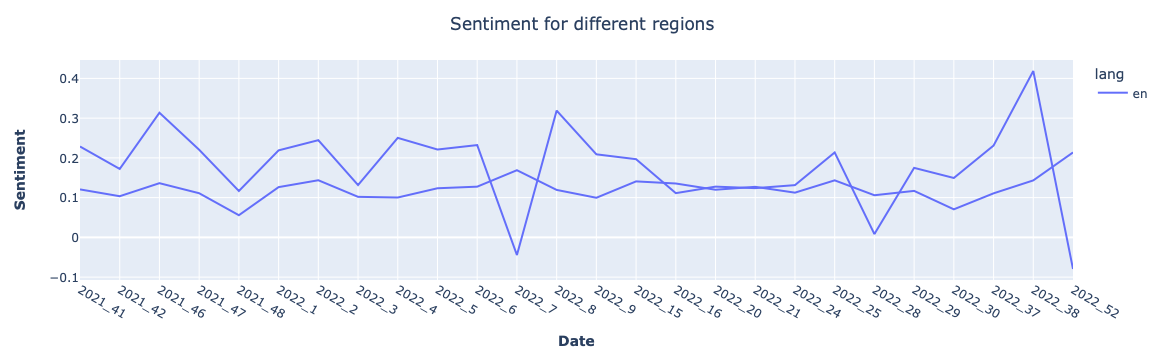

In [19]:
fig = px.line(df_sentiment, x='date', y=df_sentiment.columns[3:5], color='lang')

    # Add figure title
fig.update_layout(
        title_text="Sentiment for different regions",
        title_x = 0.5
    )

    # add axes
fig.update_xaxes(title_text="<b>Date</b>")
fig.update_yaxes(title_text="<b>Sentiment</b>")

fig.show()